
# 숙명여자대학교 기계시스템학부 딥러닝 2025: Lab6

## Topic: **Synthetic UI Element Detection Dataset Generator**
## (강사: 심주용)

Creat a synthetic dataset for training object detection models to recognize user interface (UI) components, specifically **icons** and **panels**.

## Features

- **Verified Public Icons**: Downloads a curated list of public icons from [Icons8](https://icons8.com/).
- **Realistic Layouts**: Generates panels that are either vertically or horizontally elongated.
- **Aligned Icons**: Icons are placed in a single row or column aligned with the orientation of each panel.
- **Dynamic Panel Sizing**: Each panel’s size adjusts based on the number and size of icons it contains.
- **Non-Overlapping Panels**: Ensures that no two panels overlap in a single image.
- **Object Detection Annotations**: Outputs labels in YOLO format (`class x_center y_center width height`) for both icons (class `0`) and panels (class `1`).

## Output

- `images/`: Contains generated synthetic UI images.
- `labels/`: Contains corresponding YOLO-format annotation `.txt` files.

This setup is ideal for creating training data for UI automation, accessibility tools, or mobile app design analysis.


# Generate Train Data

In [ ]:
import os
import requests
from PIL import Image, ImageDraw, UnidentifiedImageError
from io import BytesIO
import random

# Define directories
os.makedirs('datasets', exist_ok=True)
images_path = 'datasets/icon/images/train'
labels_path = 'datasets/icon/labels/train'
os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

# Verified list of public icon URLs
icons_base_url = "https://img.icons8.com/color/96/000000/"
icon_names = [
    "home--v1", "settings--v1", "search--v1", "user-male-circle--v1", "calendar--v1", "camera--v1", "phone--v1", "lock--v1", "cloud--v1",
    "facebook", "twitter", "instagram", "linkedin", "whatsapp", "youtube", "github", "google-logo", "dropbox", "spotify",
    "paypal", "visa", "mastercard", "bitcoin", "alarm", "windows-10", "android-os", "ubuntu", "linux",
    "trash", "download", "upload", "edit", "copy", "paste", "print", "refresh", "save",
    "bookmark", "shopping-cart", "tag", "star", "bell", "document", "briefcase", "key", "map",
    "clock", "gift", "graph", "chat", "network", "shield", "lightning-bolt", "rocket",
    "puzzle", "trophy", "globe", "flag", "compass", "paper-plane", "thumbs-down", "play", "pause",
    "stop", "rewind", "forward", "microphone", "headphones", "speaker", "video",
    "music", "film-reel", "paint-palette", "scissors", "hammer", "wrench", "gear", "car", "bus",
    "train", "bicycle", "motorcycle", "flower", "sun", "moon", "snowflake"
]
icons = [f"{icons_base_url}{name}.png" for name in icon_names]

# Cache downloaded icons to avoid repeated requests
icon_cache = {}

def download_icon(url):
    if url not in icon_cache:
        response = requests.get(url)
        try:
            icon_cache[url] = Image.open(BytesIO(response.content)).convert("RGBA")
        except UnidentifiedImageError:
            print(f"Failed to load image from URL: {url}")
            icon_cache[url] = None
    return icon_cache[url]

def is_overlapping(box1, box2):
    return not (box1[2] <= box2[0] or box1[0] >= box2[2] or box1[3] <= box2[1] or box1[1] >= box2[3])

def generate_synthetic_image(img_idx):
    panel_width, panel_height = 800, 470
    panel_color = tuple(random.randint(150, 255) for _ in range(3))
    panel = Image.new("RGB", (panel_width, panel_height), panel_color)
    draw = ImageDraw.Draw(panel)

    num_panels = random.randint(3, 10)
    annotations = []
    existing_boxes = []

    attempts = 0
    while len(existing_boxes) < num_panels and attempts < 50:
        arrange_vertical = random.choice([True, False])
        num_icons = random.randint(2, 6)
        icon_spacing = 10
        icon_size = random.randint(40, 60)

        if arrange_vertical:
            panel_w = icon_size + 20
            panel_h = num_icons * icon_size + (num_icons - 1) * icon_spacing + 20
        else:
            panel_w = num_icons * icon_size + (num_icons - 1) * icon_spacing + 20
            panel_h = icon_size + 20

        panel_x = random.randint(0, panel_width - panel_w)
        panel_y = random.randint(0, panel_height - panel_h)
        panel_box = [panel_x, panel_y, panel_x + panel_w, panel_y + panel_h]

        if any(is_overlapping(panel_box, eb) for eb in existing_boxes):
            attempts += 1
            continue

        existing_boxes.append(panel_box)
        panel_color_inner = tuple(random.randint(100, 200) for _ in range(3))
        draw.rectangle(panel_box, fill=panel_color_inner)

        x_center = (panel_x + panel_w / 2) / panel_width
        y_center = (panel_y + panel_h / 2) / panel_height
        width = panel_w / panel_width
        height = panel_h / panel_height
        annotations.append(f"1 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        for i in range(num_icons):
            icon_url = random.choice(icons)
            icon = download_icon(icon_url)

            if icon is None:
                continue

            icon_resized = icon.resize((icon_size, icon_size))

            if arrange_vertical:
                icon_x = panel_x + (panel_w - icon_size) // 2
                icon_y = panel_y + 10 + i * (icon_size + icon_spacing)
            else:
                icon_x = panel_x + 10 + i * (icon_size + icon_spacing)
                icon_y = panel_y + (panel_h - icon_size) // 2

            panel.paste(icon_resized, (icon_x, icon_y), icon_resized)

            x_center_icon = (icon_x + icon_size / 2) / panel_width
            y_center_icon = (icon_y + icon_size / 2) / panel_height
            width_icon = icon_size / panel_width
            height_icon = icon_size / panel_height
            annotations.append(f"0 {x_center_icon:.6f} {y_center_icon:.6f} {width_icon:.6f} {height_icon:.6f}")

        attempts += 1

    img_path = os.path.join(images_path,f'synthetic_{img_idx}.png')
    panel.save(img_path)

    annotation_path = os.path.join(labels_path,f'synthetic_{img_idx}.txt')
    with open(annotation_path, 'w') as f:
        for annotation in annotations:
            f.write(annotation + "\n")

for i in range(100):
    generate_synthetic_image(i)

print("Synthetic UI dataset generated with non-overlapping panels and aligned icons!")

Synthetic UI dataset generated with non-overlapping panels and aligned icons!


# Generate Validation Data

In [ ]:
import os
import requests
from PIL import Image, ImageDraw, UnidentifiedImageError
from io import BytesIO
import random

# Define directories
os.makedirs('datasets', exist_ok=True)
images_path = 'datasets/icon/images/val'
labels_path = 'datasets/icon/labels/val'
os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

# Verified list of public icon URLs
icons_base_url = "https://img.icons8.com/color/96/000000/"
icon_names = [
    "home--v1", "settings--v1", "search--v1", "user-male-circle--v1", "calendar--v1", "camera--v1", "phone--v1", "lock--v1", "cloud--v1",
    "facebook", "twitter", "instagram", "linkedin", "whatsapp", "youtube", "github", "google-logo", "dropbox", "spotify",
    "paypal", "visa", "mastercard", "bitcoin", "alarm", "windows-10", "android-os", "ubuntu", "linux",
    "trash", "download", "upload", "edit", "copy", "paste", "print", "refresh", "save",
    "bookmark", "shopping-cart", "tag", "star", "bell", "document", "briefcase", "key", "map",
    "clock", "gift", "graph", "chat", "network", "shield", "lightning-bolt", "rocket",
    "puzzle", "trophy", "globe", "flag", "compass", "paper-plane", "thumbs-down", "play", "pause",
    "stop", "rewind", "forward", "microphone", "headphones", "speaker", "video",
    "music", "film-reel", "paint-palette", "scissors", "hammer", "wrench", "gear", "car", "bus",
    "train", "bicycle", "motorcycle", "flower", "sun", "moon", "snowflake"
]
icons = [f"{icons_base_url}{name}.png" for name in icon_names]

# Cache downloaded icons to avoid repeated requests
icon_cache = {}

def download_icon(url):
    if url not in icon_cache:
        response = requests.get(url)
        try:
            icon_cache[url] = Image.open(BytesIO(response.content)).convert("RGBA")
        except UnidentifiedImageError:
            print(f"Failed to load image from URL: {url}")
            icon_cache[url] = None
    return icon_cache[url]

def is_overlapping(box1, box2):
    return not (box1[2] <= box2[0] or box1[0] >= box2[2] or box1[3] <= box2[1] or box1[1] >= box2[3])

def generate_synthetic_image(img_idx):
    panel_width, panel_height = 800, 470
    panel_color = tuple(random.randint(150, 255) for _ in range(3))
    panel = Image.new("RGB", (panel_width, panel_height), panel_color)
    draw = ImageDraw.Draw(panel)

    num_panels = random.randint(1, 4)
    annotations = []
    existing_boxes = []

    attempts = 0
    while len(existing_boxes) < num_panels and attempts < 50:
        arrange_vertical = random.choice([True, False])
        num_icons = random.randint(2, 6)
        icon_spacing = 10
        icon_size = random.randint(40, 60)

        if arrange_vertical:
            panel_w = icon_size + 20
            panel_h = num_icons * icon_size + (num_icons - 1) * icon_spacing + 20
        else:
            panel_w = num_icons * icon_size + (num_icons - 1) * icon_spacing + 20
            panel_h = icon_size + 20

        panel_x = random.randint(0, panel_width - panel_w)
        panel_y = random.randint(0, panel_height - panel_h)
        panel_box = [panel_x, panel_y, panel_x + panel_w, panel_y + panel_h]

        if any(is_overlapping(panel_box, eb) for eb in existing_boxes):
            attempts += 1
            continue

        existing_boxes.append(panel_box)
        panel_color_inner = tuple(random.randint(100, 200) for _ in range(3))
        draw.rectangle(panel_box, fill=panel_color_inner)

        x_center = (panel_x + panel_w / 2) / panel_width
        y_center = (panel_y + panel_h / 2) / panel_height
        width = panel_w / panel_width
        height = panel_h / panel_height
        annotations.append(f"1 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        for i in range(num_icons):
            icon_url = random.choice(icons)
            icon = download_icon(icon_url)

            if icon is None:
                continue

            icon_resized = icon.resize((icon_size, icon_size))

            if arrange_vertical:
                icon_x = panel_x + (panel_w - icon_size) // 2
                icon_y = panel_y + 10 + i * (icon_size + icon_spacing)
            else:
                icon_x = panel_x + 10 + i * (icon_size + icon_spacing)
                icon_y = panel_y + (panel_h - icon_size) // 2

            panel.paste(icon_resized, (icon_x, icon_y), icon_resized)

            x_center_icon = (icon_x + icon_size / 2) / panel_width
            y_center_icon = (icon_y + icon_size / 2) / panel_height
            width_icon = icon_size / panel_width
            height_icon = icon_size / panel_height
            annotations.append(f"0 {x_center_icon:.6f} {y_center_icon:.6f} {width_icon:.6f} {height_icon:.6f}")

        attempts += 1

    img_path = os.path.join(images_path,f'synthetic_{img_idx}.png')
    panel.save(img_path)

    annotation_path = os.path.join(labels_path,f'synthetic_{img_idx}.txt')
    with open(annotation_path, 'w') as f:
        for annotation in annotations:
            f.write(annotation + "\n")

for i in range(50):
    generate_synthetic_image(i)

print("Synthetic UI dataset generated with non-overlapping panels and aligned icons!")

Synthetic UI dataset generated with non-overlapping panels and aligned icons!


# Setup

pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![Downloads](https://static.pepy.tech/badge/ultralytics)](https://www.pepy.tech/projects/ultralytics) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.3/112.6 GB disk)


# Train

In [ ]:
!pwd

/content


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='icon.yaml', epochs=50, imgsz=800)  # train the model

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=icon.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fal

train: Scanning /content/datasets/icon/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 266.5±99.0 MB/s, size: 18.9 KB)


val: Scanning /content/datasets/icon/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.38G      1.678      3.486      1.278        218        800: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         50        624     0.0112      0.548      0.464      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.22G       1.17      2.683      1.065        164        800: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         50        624     0.0392      0.943       0.52      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.24G     0.9587      1.256     0.9437        314        800: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         50        624      0.979        0.5      0.835      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.67G     0.8533     0.8581     0.9106        169        800: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         50        624      0.985      0.509      0.974      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.67G     0.7757     0.7655     0.9047        149        800: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         50        624      0.959      0.909      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.67G     0.7246     0.6766     0.8795        199        800: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         50        624      0.855      0.947      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.67G     0.6928     0.6328     0.8704        166        800: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         50        624      0.761      0.982      0.963       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.67G     0.7004     0.6375     0.8687        200        800: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         50        624      0.806      0.938      0.978      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.67G     0.6602     0.6176     0.8645        175        800: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         50        624      0.924      0.813      0.994      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.67G     0.6585     0.5878     0.8562        179        800: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         50        624       0.98       0.98      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.67G     0.6453     0.5842      0.859        292        800: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         50        624      0.991      0.994      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.69G     0.5874     0.5591     0.8486        145        800: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         50        624      0.998          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.69G     0.5547     0.5257     0.8444        291        800: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         50        624      0.997          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.71G     0.5644     0.5085     0.8386        158        800: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         50        624      0.941      0.991      0.994      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.71G     0.5481     0.5088     0.8347        238        800: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         50        624      0.948      0.963      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.71G     0.5416     0.4959     0.8319        255        800: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


                   all         50        624      0.996      0.999      0.995      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.72G     0.5176     0.4932     0.8316        165        800: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         50        624      0.997          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.19G     0.4983     0.4813     0.8331        135        800: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         50        624      0.999          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.19G     0.5121     0.4595     0.8223        233        800: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         50        624      0.997          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.19G     0.5002     0.4854     0.8231        121        800: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         50        624      0.998          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.21G     0.4924     0.4652      0.822        324        800: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         50        624      0.997          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.21G     0.4712     0.4366     0.8243        241        800: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         50        624      0.997      0.998      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.21G     0.4874     0.4468      0.828        214        800: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50        624      0.997          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.22G     0.4796     0.4316     0.8186        196        800: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         50        624      0.997          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.22G     0.4611     0.4288     0.8241        219        800: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         50        624      0.997          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.22G     0.4611     0.4206     0.8162        191        800: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         50        624      0.998          1      0.995      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.22G     0.4511     0.4341     0.8263        162        800: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         50        624      0.998          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.22G     0.4284     0.4107     0.8144        209        800: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         50        624      0.998          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.22G     0.4084     0.4048     0.8171        237        800: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         50        624      0.998          1      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.22G     0.4123     0.3941     0.8132        233        800: 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         50        624      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.22G     0.4105     0.3957     0.8155        294        800: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50        624      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.22G     0.3955       0.39     0.8135        169        800: 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         50        624      0.999          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.22G     0.4043     0.3992      0.809        239        800: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         50        624      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.22G     0.3856     0.3908     0.8125        142        800: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         50        624      0.999          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.22G     0.3778     0.3963      0.812        108        800: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         50        624      0.999          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.22G      0.376     0.3742     0.8079        158        800: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50        624      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.22G     0.3815     0.3762     0.8059        227        800: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         50        624      0.999          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.22G     0.3782     0.3676     0.8081        238        800: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50        624      0.999          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.22G     0.3716     0.3749     0.8093        134        800: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


                   all         50        624      0.999          1      0.995      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.22G     0.3697     0.3716     0.8077        251        800: 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         50        624      0.999          1      0.995      0.965


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.22G      0.343     0.4181     0.7956        111        800: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         50        624      0.999          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.22G     0.3324     0.3826     0.7933        131        800: 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         50        624      0.998          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.22G     0.3439     0.3927     0.7884        107        800: 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         50        624      0.998          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.22G     0.3313     0.4002     0.7917         98        800: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50        624      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.22G     0.3325     0.3705     0.7919        119        800: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         50        624      0.999          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.22G      0.324     0.3538     0.7942        105        800: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         50        624      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.22G     0.3229     0.3618     0.7941        123        800: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         50        624      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.22G       0.31     0.3433     0.7855        123        800: 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         50        624      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.22G     0.3185     0.3416     0.7883        132        800: 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         50        624      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.22G     0.3024     0.3428     0.7793        139        800: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         50        624      0.999          1      0.995      0.971



50 epochs completed in 0.046 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


                   all         50        624      0.998          1      0.995      0.973
                  icon         50        501          1          1      0.995      0.951
                 panel         50        123      0.995          1      0.995      0.995
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train4


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data='icon.yaml', epochs=5, imgsz=800)  # train the model

100%|██████████| 6.25M/6.25M [00:00<00:00, 102MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=icon.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 93.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.6±4.4 MB/s, size: 32.6 KB)


train: Scanning /content/datasets/icon/labels/train... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1365.31it/s]

train: New cache created: /content/datasets/icon/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.5±4.3 MB/s, size: 18.9 KB)


val: Scanning /content/datasets/icon/labels/val... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 468.80it/s]

val: New cache created: /content/datasets/icon/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.89G      1.653      3.593      1.227        218        640: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         50        624     0.0119      0.559      0.354       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.44G      1.237      3.025      1.055        164        640: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         50        624     0.0303      0.793      0.507      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.46G      1.029      1.887     0.9461        315        640: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         50        624          1      0.459      0.532      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.47G     0.9197      1.323     0.9225        169        640: 100%|██████████| 7/7 [00:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         50        624      0.993       0.48      0.668      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.78G     0.8764      1.081      0.915        149        640: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

                   all         50        624      0.997      0.484       0.93      0.766



5 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         50        624      0.997      0.484      0.929      0.766
                  icon         50        501          1          0      0.864      0.668
                 panel         50        123      0.993      0.967      0.994      0.864
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train


# Validation

In [ ]:
results = model.val()  # evaluate model performance on the validation set

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 443.0±132.2 MB/s, size: 16.4 KB)


val: Scanning /content/datasets/icon/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


                   all         50        624      0.998          1      0.995      0.974
                  icon         50        501          1          1      0.995      0.953
                 panel         50        123      0.995          1      0.995      0.995
Speed: 9.4ms preprocess, 9.6ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to runs/detect/train42


In [ ]:
results = model.val()  # evaluate model performance on the validation set

Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 810.0±298.2 MB/s, size: 16.4 KB)


val: Scanning /content/datasets/icon/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


                   all         50        624      0.997      0.484       0.93      0.767
                  icon         50        501          1          0      0.865       0.67
                 panel         50        123      0.993      0.967      0.994      0.863
Speed: 6.9ms preprocess, 8.2ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
!ls -al

total 12028
drwxr-xr-x 1 root root    4096 May 26 07:25 .
drwxr-xr-x 1 root root    4096 May 26 07:20 ..
drwxr-xr-x 4 root root    4096 May 14 13:38 .config
drwxr-xr-x 3 root root    4096 May 26 07:16 datasets
-rw-r--r-- 1 root root     846 May 26 07:21 icon.yaml
drwxr-xr-x 3 root root    4096 May 26 07:21 runs
-rw-r--r-- 1 root root  115425 May 26 07:25 test_img.png
-rw-r--r-- 1 root root 5613764 May 26 07:21 yolo11n.pt
-rw-r--r-- 1 root root 6549796 May 26 07:21 yolov8n.pt


In [ ]:
result = model("test_img.png")


image 1/1 /content/test_img.png: 448x640 (no detections), 38.2ms
Speed: 8.0ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
# prompt: show the result of object detection

# You can also inspect the prediction details
# For example, printing the boxes and scores for the first image result
if result and hasattr(result[0], 'boxes'):
    print("\nDetection Results (Boxes, Classes, Scores):")
    for box in result[0].boxes:
        xyxy = box.xyxy.tolist()[0]  # bounding box in [x1, y1, x2, y2] format
        confidence = box.conf.item() # confidence score
        class_id = int(box.cls.item()) # class id
        # Assuming class names are available in the model or a separate list
        class_name = model.names[class_id] if hasattr(model, 'names') else f"Class {class_id}"
        print(f"Object: {class_name}, Box: {xyxy}, Confidence: {confidence:.2f}")
else:
     print("\nNo detection results found or structure is unexpected.")



Detection Results (Boxes, Classes, Scores):



image 1/1 /content/test_img.png: 544x800 41 icons, 7 panels, 36.3ms
Speed: 3.9ms preprocess, 36.3ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 800)


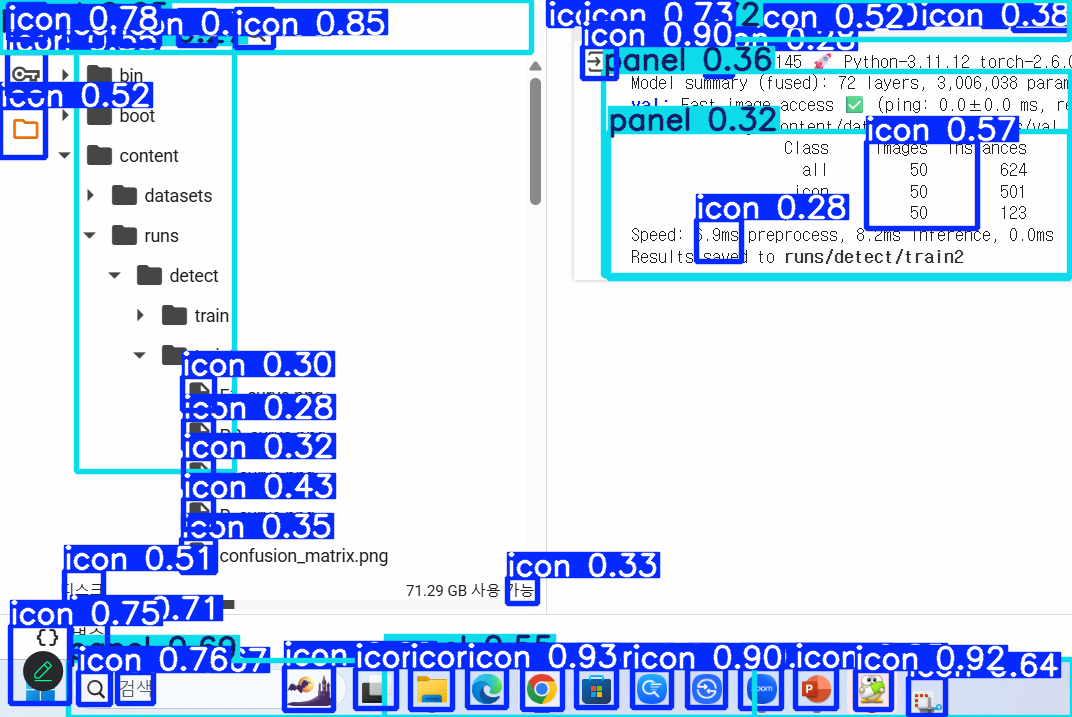

In [ ]:
# prompt: show the result of object detection as an detected image

from google.colab.patches import cv2_imshow
import cv2

# Assuming result is the output from model("test_img.png")
# result is a list of Results objects, one for each input image.
# Access the first image's result.
results = model("test_img.png") # Example using a generated image
result_img = results[0]

# The 'plot()' method draws the bounding boxes and labels on the image.
# It returns the annotated image as a NumPy array in BGR format (suitable for OpenCV).
im_bgr = result_img.plot()

# Convert BGR to RGB (PIL Image uses RGB) if you prefer PIL for display
# im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
# pil_img = Image.fromarray(im_rgb)

# Display the image using cv2_imshow
cv2_imshow(im_bgr)

In [ ]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([], device='cuda:0')
conf: tensor([], device='cuda:0')
data: tensor([], device='cuda:0', size=(0, 6))
id: None
is_track: False
orig_shape: (717, 1072)
shape: torch.Size([0, 6])
xywh: tensor([], device='cuda:0', size=(0, 4))
xywhn: tensor([], device='cuda:0', size=(0, 4))
xyxy: tensor([], device='cuda:0', size=(0, 4))
xyxyn: tensor([], device='cuda:0', size=(0, 4))